In [3]:
import azureml.core
# Packages to load Workspace and get registered Models
from azureml.core import Workspace, Model
# Package to load define Environment dependencies
from azureml.core.conda_dependencies import CondaDependencies 

# Packages for deployment
from azureml.core.webservice import AksWebservice
from azureml.core.model import InferenceConfig

import os, shutil

In [4]:
#*###########################
#* CONNECT TO THE WORKSPACE
#*
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.31.0 to work with ws_Machine_Learning


In [5]:
#*###########################
#* GET THE DESIRE MODEL FROM
#* THE WORKSPACE
#*
# Print all models in the workspace 
for model in Model.list(ws):
    print(model.name, 'version:', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

# Get the model to deploy
model = ws.models['Conv2DNet']
print('Loaded ', model.name, 'model version', model.version)

Conv2DNet version: 3


Conv2DNet version: 2


Conv2DNet version: 1


Conv2DNet_test version: 3


Conv2DNet_test version: 2


Conv2DNet_test version: 1


Loaded  Conv2DNet model version 3


In [6]:
#*###########################
#* CREATE WEBSERVICE TO HOST
#* THE MODEL
#*
folder_name = 'brain_classification_service'

# Create a folder for the web service files
source_directory = './' + folder_name
os.makedirs(source_directory, exist_ok=True)
print(folder_name, 'folder created.')

# Copy the necessary Python files into the experiment folder
shutil.copy('./score_brain.py', os.path.join(source_directory, "score_brain.py"))
shutil.copy('./preProcessing_chain.py', os.path.join(source_directory, "preProcessing_chain.py"))
shutil.copy('./metrics.py', os.path.join(source_directory, "metrics.py"))
shutil.copy('./nn_models.py', os.path.join(source_directory, "nn_models.py"))
shutil.copy('./hsi_dataManager.py', os.path.join(source_directory, "hsi_dataManager.py"))

brain_classification_service folder created.


'./brain_classification_service\\hsi_dataManager.py'

In [7]:
#*###########################
#* INDICATE CONTAINER HOST
#* TO INSTALL OUR REQUIRED
#* PYTHON DEPENDENCIES
#*

# Add the dependencies for our model (AzureML defaults is already included)
myenv = CondaDependencies.create(conda_packages=['scikit-learn','ipykernel','matplotlib','numpy', 'pillow', 'pip'],
                                                pip_packages=['azureml-sdk', 'azureml-defaults', 'pyarrow==3.0.0', 'torch', 'scipy', 'tqdm'],
                                                python_version='3.8.10')

# Save the environment config as a .yml file
env_file = os.path.join(source_directory, "brain_env.yml")

with open(env_file, "w") as f:
    f.write(myenv.serialize_to_string())

print("Saved dependency info in", env_file)

Saved dependency info in ./brain_classification_service\brain_env.yml


In [8]:
#*###########################
#* DEPLOY THE MODEL AS A 
#* WEBSERVICE
#*
from azureml.core.webservice import AksEndpoint
from azureml.core.compute import ComputeTarget, AksCompute

# ACI only have 60 seconds timeout on the run(). Therefore we need to use AKS
# ACI does not have GPU cores, so we cannot predict with our CNN models using CUDA 
aks_name = 'aks-cluster'

# Select a created compute
compute = AksCompute(ws, aks_name)

# Create the deployment config and define the scoring traffic percentile for the first deployment
deployment_config = AksEndpoint.deploy_configuration(cpu_cores = 0.1, memory_gb = 0.5, gpu_cores = 0.1, timeout_seconds=240)

# Configure the scoring environment
inference_config = InferenceConfig(entry_script="score_brain.py",
                                    source_directory=source_directory,
                                    conda_file="brain_env.yml",
                                    runtime= "python")

service_name = 'brain-service'

service = Model.deploy(ws, service_name, [model], inference_config, deployment_config, compute)

service.wait_for_deployment(True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-06-29 00:07:34+02:00 Creating Container Registry if not exists.
2021-06-29 00:07:34+02:00 Registering the environment.
2021-06-29 00:07:35+02:00 Use the existing image for brain-service.
2021-06-29 00:07:37+02:00 Creating resources in AKS.
2021-06-29 00:07:37+02:00 Submitting deployment to compute.
2021-06-29 00:07:39+02:00 Checking the status of deployment brain-service..
2021-06-29 00:07:52+02:00 Checking the status of inference endpoint brain-service.
Succeeded
AKSENDPOINT service creation operation finished, operation "Succeeded"
Healthy


Done serializing data to JSON
Received data from scoring script!


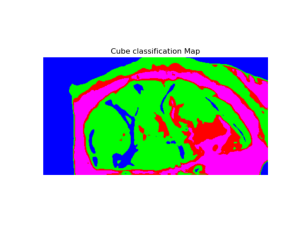

In [9]:
# Packages to connect to the container and send requests 
import requests
import urllib.request
import json
from json import JSONEncoder


# Packages to load data
from PIL import Image
import numpy as np
import os
import io
import matplotlib.pyplot as plt

#*##########################
#* NumpyArrayEncoder class
#*
class NumpyArrayEncoder(JSONEncoder):
    """
    Class to serialize Numpy arrays to JSON objects.
    Other object instances are enconded by default.
    """
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

#*
#* END NumpyArrayEncoder class
#*#############################


def readimage(path):

    count = os.stat(path).st_size / 2
    with open(path, "rb") as f:
        return bytearray(f.read())

#*###############
#* DATA LOADING
#*
# Tif images path
brainImage = './NEMESIS_images/tif/ID0035C02.tif'
whiteImage = './NEMESIS_images/tif/ID0035CW02.tif'
blackImage = './NEMESIS_images/tif/ID0035CD07.tif'

# Load tif images
raw_image = np.array(Image.open(brainImage))
white_ref = np.array(Image.open(whiteImage))
black_ref = np.array(Image.open(blackImage))

# Batch and patch sizes
patch_size = 7
batch_size = 16

#*###########################
#* CONNECT TO WEBSERVICE
#* AND PREPARE DATA TO SEND
#*

# Python dictionary to serialize as a JSON object
data = {
    "raw_image": raw_image,
    "white_ref": white_ref,
    "black_ref": black_ref,
    "patch_size": patch_size,
    "batch_size": batch_size
}

# Serializing Python dictionary as json object using the NumpyArrayEncoder class 
# to properly serialize ndarrays.
body = json.dumps(data, cls=NumpyArrayEncoder)
print("Done serializing data to JSON")

response = service.run(input_data = body)
print("Received data from scoring script!")

dictionary = json.loads(response)

classification_map = np.asarray(dictionary['classification_map'])


plt.imshow(classification_map)
plt.axis("off")   # turns off axes
plt.axis("tight")  # gets rid of white border
plt.axis("image")  # square up the image instead of filling the "figure" space
plt.savefig("classificationMap.png", bbox_inches='tight')
plt.show()

In [14]:
fig = plt.imshow(classification_map)
plt.axis("off")   # turns off axes
fig.set_dpi(70.0)
plt.show()

AttributeError: 'AxesImage' object has no attribute 'set_dpi'

In [32]:
service.get_logs()

'{"brain-service":"2021-06-28T21:01:27,305796334+00:00 - gunicorn/run \\nFile not found: /var/azureml-app/.\\nStarting HTTP server\\n2021-06-28T21:01:27,306354130+00:00 - rsyslog/run \\n2021-06-28T21:01:27,315272969+00:00 - iot-server/run \\n2021-06-28T21:01:27,323579913+00:00 - nginx/run \\nrsyslogd: /azureml-envs/azureml_1d0fd58927f644d17e0704f346dd9666/lib/libuuid.so.1: no version information available (required by rsyslogd)\\nEdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...\\n2021-06-28T21:01:27,439273831+00:00 - iot-server/finish 1 0\\n2021-06-28T21:01:27,443311703+00:00 - Exit code 1 is normal. Not restarting iot-server.\\nStarting gunicorn 20.1.0\\nListening at: http://127.0.0.1:31311 (11)\\nUsing worker: sync\\nworker timeout is set to 300\\nBooting worker with pid: 37\\nSPARK_HOME not set. Skipping PySpark Initialization.\\nGenerating new fontManager, this may take some time...\\nInitializing logger\\n2021-06-28 21:01:30,201 | root | INFO | Starting u